In [1]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm


In [2]:

class Generator(nn.Module):
    """Image generator
    
    Takes a noise vector as input and syntheses a single channel image accordingly
    """

    def __init__(self, input_dims, output_dims):
        """Init function
        
        Declare the network structure as indicated in CW2 Guidance
        
        Arguments:
            input_dims {int} -- Dimension of input noise vector
            output_dims {int} -- Dimension of the output vector (flatten image)
        """
        super(Generator, self).__init__()
        ###  TODO: Change the architecture and value as CW2 Guidance required

        self.fc1 = nn.Sequential(
            nn.Linear(100, 256), 
            nn.LeakyReLU(0.2)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(256, 512), 
            nn.LeakyReLU(0.2)
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(512, 1024), 
            nn.LeakyReLU(0.2)
        )  
        
        # output hidden layer
        self.fc4 = nn.Sequential(
            nn.Linear(1024, output_dims), 
            nn.Tanh()
        )

    def forward(self, x):
        """Forward function
        
        Arguments:
            x {Tensor} -- a batch of noise vectors in shape (<batch_size>x<input_dims>)
        
        Returns:
            Tensor -- a batch of flatten image in shape (<batch_size>x<output_dims>)
        """
        ###  TODO: modify to be consistent with the network structure

#        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


class Discriminator(nn.Module):
    """Image discriminator
    
    Takes a image as input and predict if it is real from the dataset or fake synthesised by the generator
    """

    def __init__(self, input_dims, output_dims=1):
        """Init function
        
        Declare the discriminator network structure as indicated in CW2 Guidance
        
        Arguments:
            input_dims {int} -- Dimension of the flatten input images
        
        Keyword Arguments:
            output_dims {int} -- Predicted probability (default: {1})
        """
        super(Discriminator, self).__init__()

        ###  TODO: Change the architecture and value as CW2 Guidance required
             
        self.fc1 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """Forward function
        
        Arguments:
            x {Tensor} -- a batch of 2D image in shape (<batch_size>xHxW)
        
        Returns:
            Tensor -- predicted probabilities (<batch_size>)
        """
        ###  TODO: modify to be consistent with the network structure

#        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x



In [3]:


def show_result(G_net, z_, num_epoch, show=False, save=False, path='result.png'):
    """Result visualisation
    
    Show and save the generated figures in the grid fashion
    
    Arguments:
        G_net {[nn.Module]} -- The generator instant
        z_ {[Tensor]} -- Input noise vectors
        num_epoch {[int]} -- Indicate how many epoch has the generator been trained
    
    Keyword Arguments:
        show {bool} -- If to display the images (default: {False})
        save {bool} -- If to store the images (default: {False})
        path {str} -- path to store the images (default: {'result.png'})
    """

    ###  TODO: complete the rest of part
    # hint: use plt.subplots to construct grid
    # hint: use plt.imshow and plt.savefig to display and store the images
    
    show_data_fake = G_net(z_)
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    
    for ax, img in zip(axes.flatten(), show_data_fake):
        img = img.detach().cpu().numpy()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()   


    

def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    """Loss tracker
    
    Plot the losses of generator and discriminator independently to see the trend
    
    Arguments:
        hist {[dict]} -- Tracking variables
    
    Keyword Arguments:
        show {bool} -- If to display the figure (default: {False})
        save {bool} -- If to store the figure (default: {False})
        path {str} -- path to store the figure (default: {'Train_hist.png'})
    """
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


def create_noise(num, dim):
    """Noise constructor
    
    returns a tensor filled with random numbers from a standard normal distribution
    
    Arguments:
        num {int} -- Number of vectors
        dim {int} -- Dimension of vectors
    
    Returns:
        [Tensor] -- the generated noise vector batch
    """
    return torch.randn(num, dim)


In [4]:
if __name__ == '__main__':
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './MNIST_data/'
    save_dir = './MNIST_GAN_results/'
    image_save_dir = './MNIST_GAN_results/results'
    generated_images = './MNIST_GAN_results/generated images'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)
    if not os.path.exists(generated_images):
        os.mkdir(generated_images)

In [5]:
    # training parameters
    batch_size = 100
    learning_rate = 0.0002
    epochs = 100

    # parameters for Models
    image_size = 28
    G_input_dim = 100
    G_output_dim = image_size * image_size
    D_input_dim = image_size * image_size
    D_output_dim = 1
    hidden_size = 32

In [6]:
    # construct the dataset and data loader
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])
    train_data = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:28<00:00, 20.79it/s]


Epoch 1 of 100 with 28.91 s
Generator loss: 3.29698603, Discriminator loss: 0.88938213


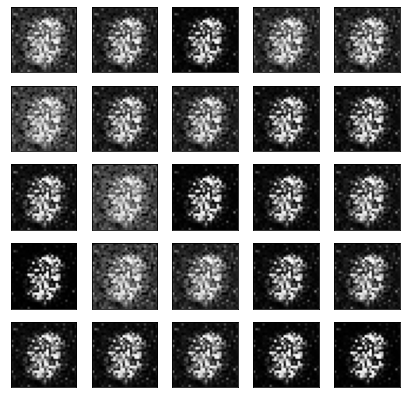

  0%|▍                                                                                 | 3/600 [00:00<00:26, 22.45it/s]

Epoch 2 of 100 with 23.13 s
Generator loss: 2.05894216, Discriminator loss: 0.91947696


  0%|▍                                                                                 | 3/600 [00:00<00:25, 23.14it/s]

Epoch 3 of 100 with 23.03 s
Generator loss: 1.97754981, Discriminator loss: 0.86867968


  0%|▍                                                                                 | 3/600 [00:00<00:27, 21.80it/s]

Epoch 4 of 100 with 23.14 s
Generator loss: 2.61128917, Discriminator loss: 0.55744573


  0%|▍                                                                                 | 3/600 [00:00<00:25, 23.69it/s]

Epoch 5 of 100 with 25.14 s
Generator loss: 2.86826594, Discriminator loss: 0.50291497


  0%|▍                                                                                 | 3/600 [00:00<00:26, 22.12it/s]

Epoch 6 of 100 with 22.94 s
Generator loss: 2.64206762, Discriminator loss: 0.57643622


  0%|▍                                                                                 | 3/600 [00:00<00:22, 26.16it/s]

Epoch 7 of 100 with 23.86 s
Generator loss: 2.73154486, Discriminator loss: 0.53507310


  0%|▍                                                                                 | 3/600 [00:00<00:26, 22.62it/s]

Epoch 8 of 100 with 24.61 s
Generator loss: 2.59574322, Discriminator loss: 0.53958350


  0%|▍                                                                                 | 3/600 [00:00<00:24, 24.66it/s]

Epoch 9 of 100 with 22.86 s
Generator loss: 2.39145360, Discriminator loss: 0.63356766


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:24<00:00, 24.36it/s]


Epoch 10 of 100 with 24.63 s
Generator loss: 2.27670733, Discriminator loss: 0.65620353


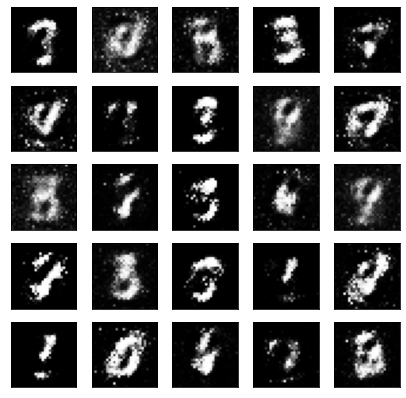

  0%|▍                                                                                 | 3/600 [00:00<00:25, 23.69it/s]

Epoch 11 of 100 with 23.41 s
Generator loss: 2.12047721, Discriminator loss: 0.71630423


  0%|▍                                                                                 | 3/600 [00:00<00:28, 20.89it/s]

Epoch 12 of 100 with 23.67 s
Generator loss: 2.05152156, Discriminator loss: 0.71876227


  0%|▍                                                                                 | 3/600 [00:00<00:27, 21.64it/s]

Epoch 13 of 100 with 23.76 s
Generator loss: 1.94320560, Discriminator loss: 0.74760814


  0%|▍                                                                                 | 3/600 [00:00<00:25, 23.14it/s]

Epoch 14 of 100 with 23.17 s
Generator loss: 1.98091769, Discriminator loss: 0.75106721


  0%|▍                                                                                 | 3/600 [00:00<00:27, 21.79it/s]

Epoch 15 of 100 with 23.10 s
Generator loss: 1.95389081, Discriminator loss: 0.77798363


  0%|▍                                                                                 | 3/600 [00:00<00:27, 21.64it/s]

Epoch 16 of 100 with 23.21 s
Generator loss: 1.83377536, Discriminator loss: 0.81479509


  0%|▍                                                                                 | 3/600 [00:00<00:26, 22.62it/s]

Epoch 17 of 100 with 23.57 s
Generator loss: 1.85956360, Discriminator loss: 0.80061025


  0%|▍                                                                                 | 3/600 [00:00<00:26, 22.12it/s]

Epoch 18 of 100 with 23.96 s
Generator loss: 1.88493882, Discriminator loss: 0.78939256


  0%|▍                                                                                 | 3/600 [00:00<00:26, 22.28it/s]

Epoch 19 of 100 with 22.76 s
Generator loss: 1.75869105, Discriminator loss: 0.84469663


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:23<00:00, 25.77it/s]


Epoch 20 of 100 with 23.29 s
Generator loss: 1.67102299, Discriminator loss: 0.86765776


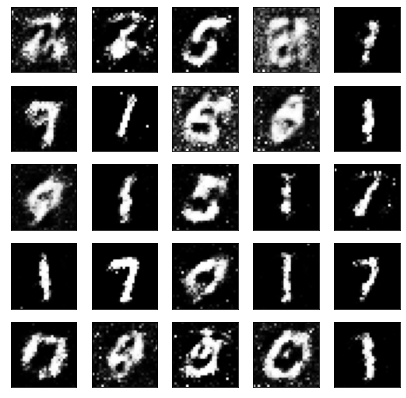

  0%|▍                                                                                 | 3/600 [00:00<00:28, 20.60it/s]

Epoch 21 of 100 with 23.25 s
Generator loss: 1.58850898, Discriminator loss: 0.92305731


  0%|▍                                                                                 | 3/600 [00:00<00:26, 22.45it/s]

Epoch 22 of 100 with 23.05 s
Generator loss: 1.52410653, Discriminator loss: 0.92992539


  0%|▍                                                                                 | 3/600 [00:00<00:26, 22.12it/s]

Epoch 23 of 100 with 23.02 s
Generator loss: 1.57149445, Discriminator loss: 0.91782448


  0%|▍                                                                                 | 3/600 [00:00<00:27, 21.64it/s]

Epoch 24 of 100 with 23.37 s
Generator loss: 1.53008010, Discriminator loss: 0.94290866


  0%|▍                                                                                 | 3/600 [00:00<00:27, 21.96it/s]

Epoch 25 of 100 with 22.73 s
Generator loss: 1.49657498, Discriminator loss: 0.96123072


  0%|▍                                                                                 | 3/600 [00:00<00:26, 22.12it/s]

Epoch 26 of 100 with 22.87 s
Generator loss: 1.48899395, Discriminator loss: 0.96627680


 16%|████████████▉                                                                    | 96/600 [00:03<00:19, 25.74it/s]

In [ ]:

    # declare the generator and discriminator networks    
    G_net = Generator(G_input_dim, G_output_dim).to(device)
    D_net = Discriminator(D_input_dim, D_output_dim).to(device)

    # Binary Cross Entropy Loss function
    criterion = nn.BCELoss().to(device)

    # Initialise the Optimizers
    G_optimizer = torch.optim.Adam(G_net.parameters(), lr=learning_rate)
    D_optimizer = torch.optim.Adam(D_net.parameters(), lr=learning_rate)

    # tracking variables
    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
    train_hist['per_epoch_ptimes'] = []
    train_hist['total_ptime'] = []

    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        G_net.train()
        D_net.train()
        Loss_G = []
        Loss_D = []
        epoch_start_time = time.time()
        for (image, _) in tqdm(train_loader):
            image = image.to(device)
            b_size = len(image)
            # creat real and fake labels
            real_label = torch.ones(b_size, 1).to(device)
            fake_label = torch.zeros(b_size, 1).to(device)

            # generate fake images 
            data_fake = G_net(create_noise(b_size, G_input_dim).to(device))
            data_real = image.view(b_size, D_input_dim)

            # --------train the discriminator network----------
            # compute the loss for real and fake images
            output_real = D_net(data_real)
            output_fake = D_net(data_fake)
            loss_real = criterion(output_real, real_label)
            loss_fake = criterion(output_fake, fake_label)
            loss_d = loss_real + loss_fake

            # back propagation
            D_optimizer.zero_grad()
            loss_d.backward()
            D_optimizer.step()

            # -------- train the generator network-----------
            data_fake = G_net(create_noise(b_size, G_input_dim).to(device))

            # compute the loss for generator network
            output_fake = D_net(data_fake)
            loss_g = criterion(output_fake, real_label)

            ## back propagation
            G_optimizer.zero_grad()
            loss_g.backward()
            G_optimizer.step()

            ## store the loss of each iter
            Loss_D.append(loss_d.item())
            Loss_G.append(loss_g.item())

        epoch_loss_g = np.mean(Loss_G)  # mean generator loss for the epoch
        epoch_loss_d = np.mean(Loss_D)  # mean discriminator loss for the epoch
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        print("Generator loss: %.8f, Discriminator loss: %.8f" % (epoch_loss_g, epoch_loss_d))

        #show opoch 1, 10, 20, 50, and 100      
        if epoch == 0 or epoch == 9 or epoch == 19 or epoch == 49 or epoch == 99:
            path = image_save_dir + '/MNIST_GAN_' + str(epoch + 1) + '.png'
            show_result(G_net, create_noise(25, 100).to(device), (epoch + 1),show=True, save=True, path=path)
        

        # record the loss for every epoch
        train_hist['G_losses'].append(epoch_loss_g)
        train_hist['D_losses'].append(epoch_loss_d)
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (
        np.mean(train_hist['per_epoch_ptimes']), epochs, total_ptime))
    print("Training finish!... save training results")
    with open(save_dir + '/train_hist.pkl', 'wb') as f:
        pickle.dump(train_hist, f)
    show_train_hist(train_hist, save=True, path=save_dir + '/MNIST_GAN_train_hist.png')

In [ ]:
    show_train_hist(train_hist, save=True, path=save_dir + '/MNIST_GAN_train_hist.png')

In [ ]:
A = np.random.rand(5, 5)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for ax, interp in zip(axs, ['nearest', 'bilinear', 'bicubic']):
    ax.imshow(A, interpolation=interp)
    ax.set_title(interp.capitalize())
    ax.grid(True)

#plt.show()